In [1]:
install.packages("BiocManager")
library(BiocManager)
BiocManager::install("DESeq2")
library("DESeq2")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Bioconductor version 3.9 (BiocManager 1.30.9), ?BiocManager::install for help
Bioconductor version 3.9 (BiocManager 1.30.9), R 3.6.1 (2019-07-05)
Installing package(s) 'DESeq2'
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'askpass', 'backports', 'boot', 'callr', 'caret', 'clipr',
  'cluster', 'curl', 'data.table', 'dbplyr', 'digest', 'dplyr', 'evaluate',
  'foreach', 'foreign', 'formatR', 'fs', 'ggplot2', 'glmnet', 'gower', 'haven',
  'hexbin', 'hms', 'htmltools', 'htmlwidgets', 'httpuv', 'httr', 'ipred',
  'IRkernel', 'iterators', 'KernSmooth', 'knitr', 'later', 'lava', 'markdown',
  'MASS', 'mgcv', 'mime', 'modelr', 'nlme', 'numDeriv', 'openssl', 'pillar',
  'pkgconfig', 'processx', 'progress', 'promises', 'purrr', 'quantmod', 'Rcpp',
  'recipes', 'repr', 'reprex', 'rmarkdown', 'rvest', 'shiny', 'sys', 'tibble',
  'tidyr', 'tinytex', 'TTR', 'whisker', 'xfun', '

In [18]:
BiocManager::install("vsn")


Bioconductor version 3.9 (BiocManager 1.30.9), R 3.6.1 (2019-07-05)
Installing package(s) 'vsn'
also installing the dependencies ‘affyio’, ‘preprocessCore’, ‘affy’, ‘limma’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'askpass', 'backports', 'boot', 'callr', 'caret', 'clipr',
  'cluster', 'curl', 'data.table', 'dbplyr', 'digest', 'dplyr', 'evaluate',
  'foreach', 'foreign', 'formatR', 'fs', 'ggplot2', 'glmnet', 'gower', 'haven',
  'hexbin', 'hms', 'htmltools', 'htmlwidgets', 'httpuv', 'httr', 'ipred',
  'IRkernel', 'iterators', 'KernSmooth', 'knitr', 'later', 'lava', 'markdown',
  'MASS', 'mgcv', 'mime', 'modelr', 'nlme', 'numDeriv', 'openssl', 'pillar',
  'pkgconfig', 'processx', 'progress', 'promises', 'purrr', 'quantmod', 'Rcpp',
  'recipes', 'repr', 'reprex', 'rmarkdown', 'rvest', 'shiny', 'sys', 'tibble',
  'tidyr', 'tinytex', 'TTR', 'whisker', 'xfun', 'xml2'


In [63]:
BiocManager::install("NMF")
library(NMF)

Bioconductor version 3.9 (BiocManager 1.30.9), R 3.6.1 (2019-07-05)
Installing package(s) 'NMF'
also installing the dependencies ‘bibtex’, ‘pkgmaker’, ‘registry’, ‘rngtools’, ‘gridBase’, ‘doParallel’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'askpass', 'backports', 'boot', 'callr', 'caret', 'clipr',
  'cluster', 'curl', 'data.table', 'dbplyr', 'digest', 'dplyr', 'evaluate',
  'foreach', 'foreign', 'formatR', 'fs', 'ggplot2', 'glmnet', 'gower', 'haven',
  'hexbin', 'hms', 'htmltools', 'htmlwidgets', 'httpuv', 'httr', 'ipred',
  'IRkernel', 'iterators', 'KernSmooth', 'knitr', 'later', 'lava', 'markdown',
  'MASS', 'mgcv', 'mime', 'modelr', 'nlme', 'numDeriv', 'openssl', 'pillar',
  'pkgconfig', 'processx', 'progress', 'promises', 'purrr', 'quantmod', 'Rcpp',
  'recipes', 'repr', 'reprex', 'rmarkdown', 'rvest', 'shiny', 'sys', 'tibble',
  'tidyr', 'tinytex', 'TTR', 'whisker', 'xfun', 'xml2'


In [67]:
BiocManager::install("EnsDb.Mmusculus.v75")
library(EnsDb.Mmusculus.v75)

Bioconductor version 3.9 (BiocManager 1.30.9), R 3.6.1 (2019-07-05)
Installing package(s) 'EnsDb.Mmusculus.v75'
also installing the dependencies ‘biomaRt’, ‘GenomicAlignments’, ‘Rhtslib’, ‘GenomicFeatures’, ‘AnnotationFilter’, ‘rtracklayer’, ‘Rsamtools’, ‘ProtGenerics’, ‘Biostrings’, ‘ensembldb’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'askpass', 'backports', 'boot', 'callr', 'caret', 'clipr',
  'cluster', 'curl', 'data.table', 'dbplyr', 'digest', 'dplyr', 'evaluate',
  'foreach', 'foreign', 'formatR', 'fs', 'ggplot2', 'glmnet', 'gower', 'haven',
  'hexbin', 'hms', 'htmltools', 'htmlwidgets', 'httpuv', 'httr', 'ipred',
  'IRkernel', 'iterators', 'KernSmooth', 'knitr', 'later', 'lava', 'markdown',
  'MASS', 'mgcv', 'mime', 'modelr', 'nlme', 'numDeriv', 'openssl', 'pillar',
  'pkgconfig', 'processx', 'progress', 'promises', 'purrr', 'quantmod', 'Rcpp',
  'recipes', 'repr', 'reprex', 'rmarkdown', 'rvest', 'shiny', 'sys', 'tibble',
  'tid

In [4]:
library(magrittr) # this will allow us to string commands together in a UNIX -pipe - like fashion using % >%

 # get the table of read counts by indicating the path to the file
readcounts <-read.table ("./raw_countstdl.tsv", header = TRUE)
head(readcounts)
str(readcounts)

,ctl1,ctl2,ctl3,ctl4,treat1,treat2,treat3,treat4
ENSMUSG00000102693,0,0,0,0,0,0,0,0
ENSMUSG00000064842,0,0,0,0,1,0,0,0
ENSMUSG00000051951,2,0,1,1,11,2,1,24
ENSMUSG00000102851,0,0,0,0,0,0,0,0
ENSMUSG00000103377,0,0,0,0,0,0,0,0
ENSMUSG00000104017,0,0,0,0,0,0,0,0


'data.frame':	45706 obs. of  8 variables:
 $ ctl1  : int  0 0 2 0 0 0 0 0 0 0 ...
 $ ctl2  : int  0 0 0 0 0 0 0 0 0 1 ...
 $ ctl3  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ ctl4  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ treat1: int  0 1 11 0 0 0 0 0 0 0 ...
 $ treat2: int  0 0 2 0 0 0 0 0 0 0 ...
 $ treat3: int  0 0 1 0 0 0 0 0 0 0 ...
 $ treat4: int  0 0 24 0 0 0 0 0 0 0 ...


In [39]:
 # make a data.frame with meta-data where row.names should match the individual sample names
 sample_info <- data.frame(condition = gsub ( "[1-4]+" , "" , names(readcounts)), row.names = names(readcounts))
 sample_info


,condition
ctl1,ctl
ctl2,ctl
ctl3,ctl
ctl4,ctl
treat1,treat
treat2,treat
treat3,treat
treat4,treat


In [40]:
 # generate the DESeqDataSet
DESeq.ds <- DESeqDataSetFromMatrix(countData = readcounts, colData = sample_info, design = ~condition )

 # check the result :
colData(DESeq.ds ) %>% head
assay(DESeq.ds, "counts" ) %>% head
rowData(DESeq.ds) %>% head


DataFrame with 6 rows and 1 column
       condition
        <factor>
ctl1         ctl
ctl2         ctl
ctl3         ctl
ctl4         ctl
treat1     treat
treat2     treat

,ctl1,ctl2,ctl3,ctl4,treat1,treat2,treat3,treat4
ENSMUSG00000102693,0,0,0,0,0,0,0,0
ENSMUSG00000064842,0,0,0,0,1,0,0,0
ENSMUSG00000051951,2,0,1,1,11,2,1,24
ENSMUSG00000102851,0,0,0,0,0,0,0,0
ENSMUSG00000103377,0,0,0,0,0,0,0,0
ENSMUSG00000104017,0,0,0,0,0,0,0,0


DataFrame with 6 rows and 0 columns

In [41]:
 # test what counts() returns
counts(DESeq.ds) %>% str

 # remove genes without any counts
DESeq.ds <- DESeq.ds [rowSums(counts(DESeq.ds)) > 0, ]

 # investigate different library sizes

colSums(counts(DESeq.ds)) == colSums(readcounts) # should be the same as colSums ( readcounts )


 int [1:45706, 1:8] 0 0 2 0 0 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:45706] "ENSMUSG00000102693" "ENSMUSG00000064842" "ENSMUSG00000051951" "ENSMUSG00000102851" ...
  ..$ : chr [1:8] "ctl1" "ctl2" "ctl3" "ctl4" ...


ctl1   ctl2   ctl3   ctl4 treat1 treat2 treat3 treat4 
  TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE

In [42]:
#DESeq2’s default method to normalize read counts to account for differences in sequencing depths is imple-
#mented in estimateSizeFactors()
#1. for every gene (= row), determine the geometric mean of its read counts across all samples (yielding
#the ”pseudo-reference”, i.e. one value per gene);
#2. divide every value of the count matrix by the corresponding pseudo-reference value;
#3. for every sample (= column), determine the median of these ratios. This is the size factor.

  # calculate the size factor and add it to the data set
DESeq.ds <- estimateSizeFactors(DESeq.ds)
sizeFactors(DESeq.ds)

 # if you check colData () again , you see that this now contains the sizeFactors
colData (DESeq.ds)

# counts () allows you to immediately retrieve the _ normalized _ read counts
counts.sf_normalized <- counts(DESeq.ds, normalized = TRUE)
 

ctl1      ctl2      ctl3      ctl4    treat1    treat2    treat3    treat4 
0.8613852 0.7601755 0.8089857 0.8337696 0.9487156 0.8192834 0.9787590 4.0539751

DataFrame with 8 rows and 2 columns
       condition        sizeFactor
        <factor>         <numeric>
ctl1         ctl 0.861385212241083
ctl2         ctl 0.760175549092362
ctl3         ctl 0.808985675298092
ctl4         ctl 0.833769556412077
treat1     treat  0.94871557100813
treat2     treat 0.819283353107582
treat3     treat 0.978758960142215
treat4     treat  4.05397505356715

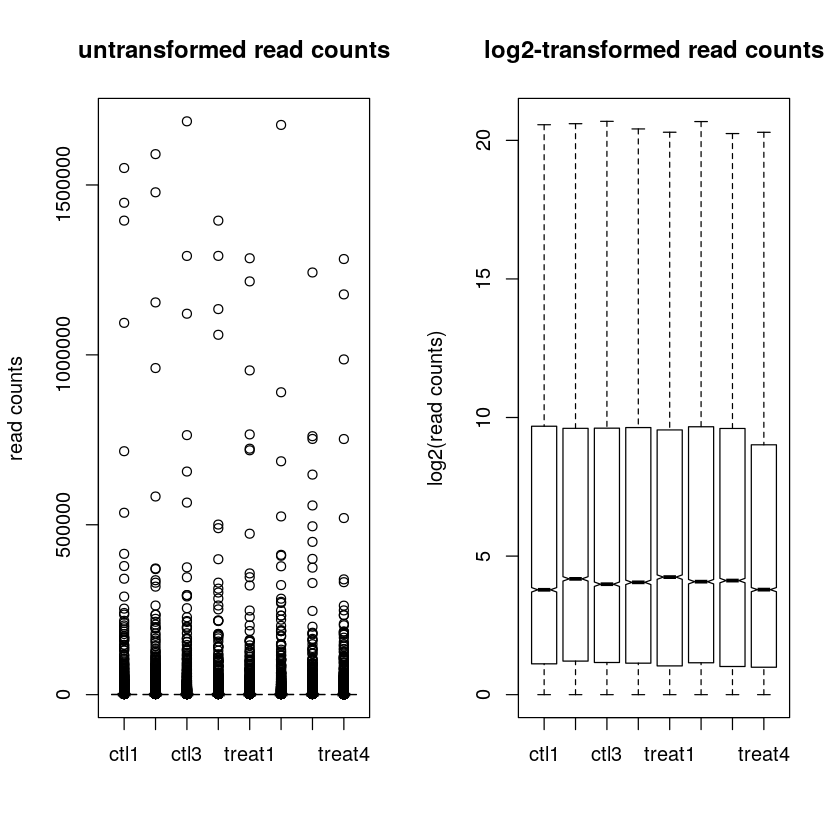

In [43]:
#5.2
#Transformation of sequencing-depth-normalized read counts
#Due to the relatively large dynamic range of expression values that RNA-seq data can cover, many down-
#stream analyses (including clustering) work much better if the read counts are transformed to the log scale
#following normalization. While you will occasionally see log10 transformed read counts, log2 is more com-
#monly used because it is easier to think about doubled values rather than powers of 10. The transformation
#should be done in addition to sequencing depth normalization.

# transform size - factor normalized read counts to log2 scale using pseudocount of 1

log.norm.counts <- log2(counts.sf_normalized + 1)

# plot the following two images underneath each other
par(mfrow = c(1,2))

# boxplots of non-transformed read counts ( one per sample )
boxplot(counts.sf_normalized, notch = TRUE , main = "untransformed read counts" , ylab = "read counts")

# box plots of log2 - transformed read counts
boxplot (log.norm.counts, notch = TRUE , main = "log2-transformed read counts" , ylab = "log2(read counts)")



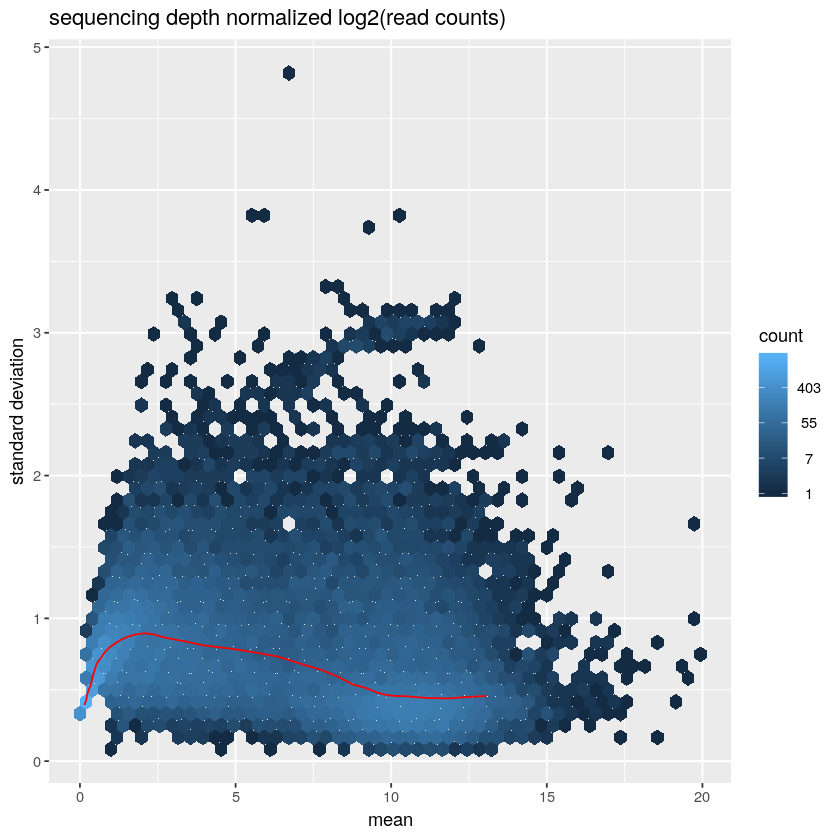

In [44]:
#Many statistical tests and analyses assume that data is homoskedastic, i.e. that all variables have similar
#variance. However, data with large differences among the sizes of the individual observations often shows
#heteroskedastic behavior. One way to visually check for heteroskedasticity is to plot the mean vs. the standard
#deviation.

 #mean - sd plot

library(vsn)
library(ggplot2)
msd_plot <- meanSdPlot(log.norm.counts, ranks = FALSE, plot = FALSE )
msd_plot$gg +
    ggtitle("sequencing depth normalized log2(read counts)") +
    ylab("standard deviation")
 




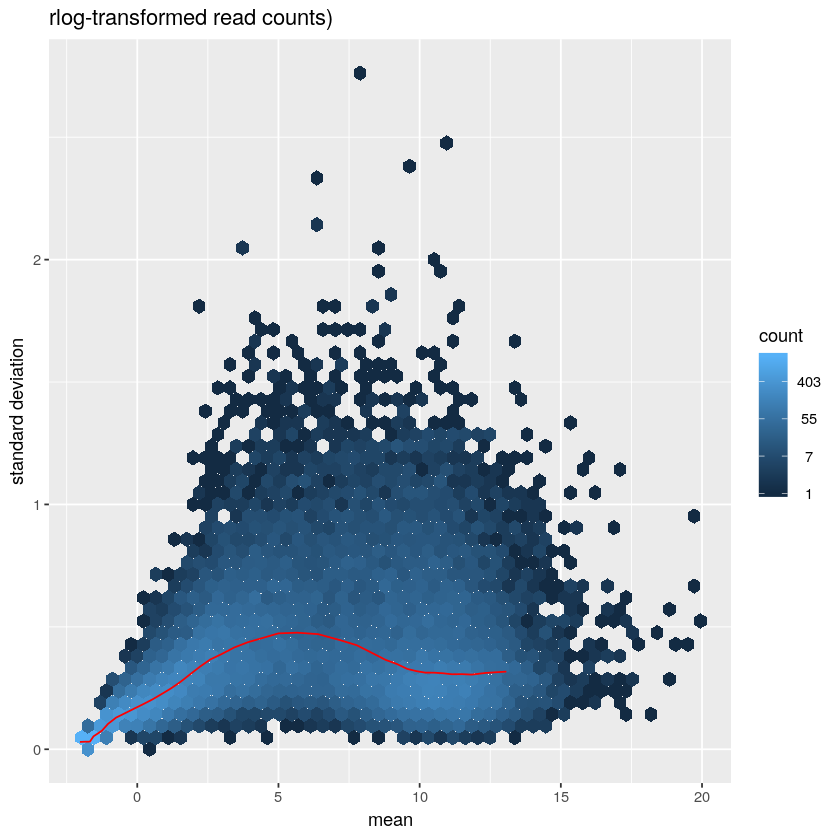

In [45]:
#Transformation of read counts including variance shrinkage
#To reduce the amount of heteroskedasticity, DESeq2 and also edgeR offer several means to shrink the variance
#of low read counts. They do this by using the dispersion-mean trend that can be observed for the entire
#data set as a reference. Consequently, genes with low and highly variable read counts will be assigned more
#homogeneous read count estimates so that their variance resembles the variance observed for the majority
#of the genes (which hopefully have a more stable variance).

  # obtain regularized log - transformed values

#The rlog() function’s blind parameter should be set to FALSE if the different conditions lead to strong differences in a large proportion of the genes. 

DESeq.rlog <- rlog(DESeq.ds , blind = FALSE )
rlog.norm.counts <- assay(DESeq.rlog)

 #mean - sd plot for rlog - transformed data

library(vsn)
library(ggplot2)
msd_plot <- meanSdPlot(rlog.norm.counts, ranks = FALSE, plot = FALSE )
msd_plot$gg +
    ggtitle("rlog-transformed read counts)") +
    ylab("standard deviation")



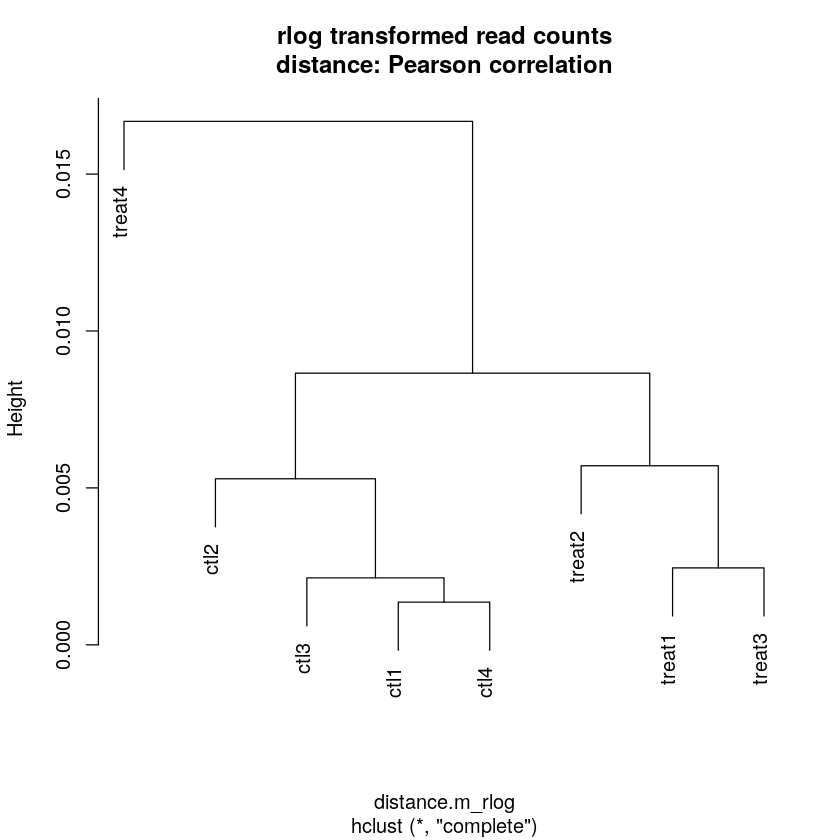

In [46]:
#A dendrogram can be generated in R using the functions cor(), as.dist(), and hclust():

# cor () calculates the correlation between columns of a matrix
distance.m_rlog <- as.dist(1 - cor(rlog.norm.counts , method = "pearson"))

# plot () can directly interpret the output of hclust ()
plot(hclust(distance.m_rlog),
    labels = colnames(rlog.norm.counts) ,
    main = "rlog transformed read counts\ndistance: Pearson correlation")


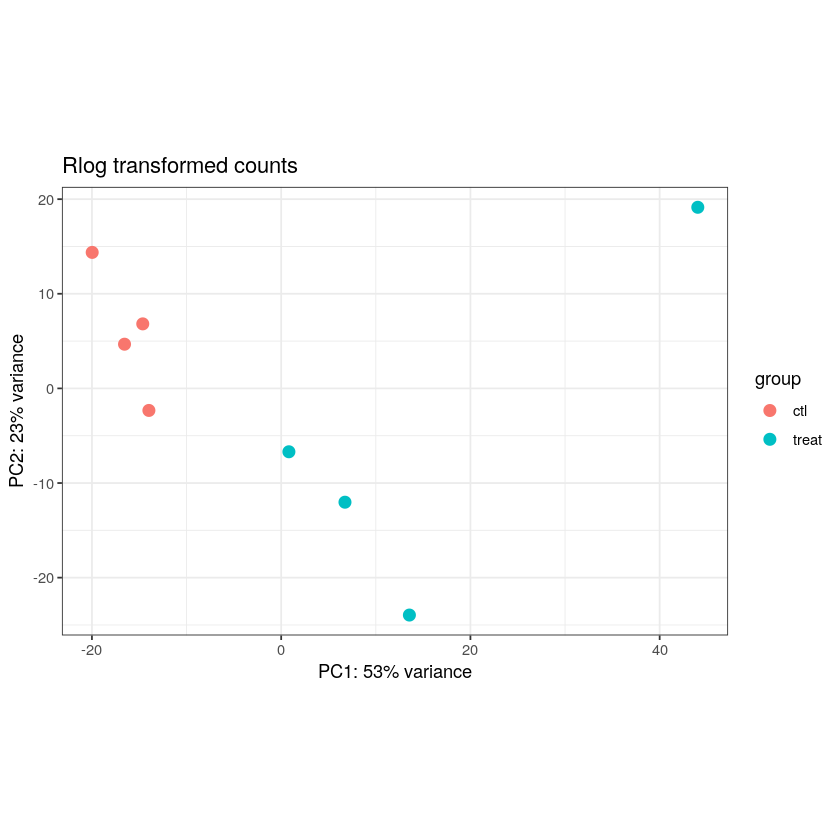

In [47]:
#DESeq2 also offers a convenience function based on ggplot2 to do PCA directly on a DESeqDataSet:

 # PCA
P <- plotPCA (DESeq.rlog)
 # plot cosmetics
P <- P + theme_bw() + ggtitle("Rlog transformed counts")
print(P)


 

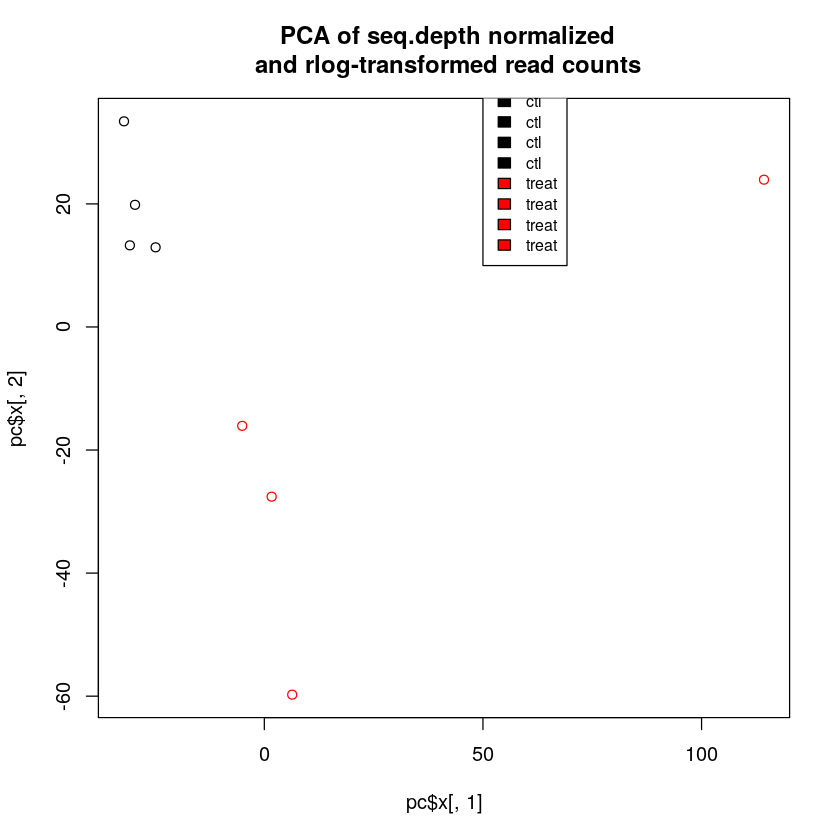

In [48]:
#PCA can be performed in base R using the function prcomp().
pc <- prcomp(t(rlog.norm.counts))

plot(pc$x[,1], pc$x[,2],
    col = colData(DESeq.ds)[,1],
    main = " PCA of seq.depth normalized\n and rlog-transformed read counts")
legend(50,40, legend = colData(DESeq.ds)[,1], col = colData(DESeq.ds)[,1], fill = colData(DESeq.ds)[,1], cex = 0.8 )


## 2.DGE Analysis

Compare the effect of the treatment (treat) versus the control(ctl) samples, with the control values used as the denominator for the fold change calculation.



In [49]:
 # DESeq2 uses the levels of the condition to determine the order of the comparison
str(colData(DESeq.ds)$condition )

 # set ctl as the first-level-factor
colData(DESeq.ds)$condition <- relevel(colData(DESeq.ds)$condition, "ctl")

# run DGE analysis
DESeq.ds <- DESeq(DESeq.ds)

 Factor w/ 2 levels "ctl","treat": 1 1 1 1 2 2 2 2


using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [51]:
DGE.results <- results(DESeq.ds, independentFiltering = TRUE, alpha = 0.05)
summary (DGE.results)

#the DESeqResult object can basically be handled like a data . frame
 head(DGE.results)
 table(DGE.results$padj < 0.05)
 rownames(subset(DGE.results, padj < 0.05))

 


out of 28474 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 946, 3.3%
LFC < 0 (down)     : 424, 1.5%
outliers [1]       : 15, 0.053%
low counts [2]     : 7729, 27%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): condition treat vs ctl 
Wald test p-value: condition treat vs ctl 
DataFrame with 6 rows and 6 columns
                            baseMean    log2FoldChange            lfcSE
                           <numeric>         <numeric>        <numeric>
ENSMUSG00000064842 0.131757086970937 0.269447026812742 3.51215336551651
ENSMUSG00000051951   3.2168660587299  2.12826823090679 1.13577774630742
ENSMUSG00000103147 0.164435701923389 -1.37687865992995 3.52860211417264
ENSMUSG00000103161 0.131757086970937 0.269447026812742 3.51215336551651
ENSMUSG00000102331 0.220214554211007  1.09401434613645  3.4603651328014
ENSMUSG00000102948 0.594666196941426 -3.07937862883515 2.17278686430102
                                 stat             pvalue              padj
                            <numeric>          <numeric>         <numeric>
ENSMUSG00000064842 0.0767184683500051  0.938847512221779                NA
ENSMUSG00000051951   1.87384216483032 0.0609521828593668 0.3130670839134


FALSE  TRUE 
19360  1370 

[1] "ENSMUSG00000033813" "ENSMUSG00000103280" "ENSMUSG00000002459"
   [4] "ENSMUSG00000090031" "ENSMUSG00000087247" "ENSMUSG00000025912"
   [7] "ENSMUSG00000048960" "ENSMUSG00000016918" "ENSMUSG00000032719"
  [10] "ENSMUSG00000085125" "ENSMUSG00000025934" "ENSMUSG00000099796"
  [13] "ENSMUSG00000037447" "ENSMUSG00000037351" "ENSMUSG00000026117"
  [16] "ENSMUSG00000026114" "ENSMUSG00000026090" "ENSMUSG00000048234"
  [19] "ENSMUSG00000026073" "ENSMUSG00000026068" "ENSMUSG00000045515"
  [22] "ENSMUSG00000100843" "ENSMUSG00000073678" "ENSMUSG00000026028"
  [25] "ENSMUSG00000026027" "ENSMUSG00000085400" "ENSMUSG00000025969"
  [28] "ENSMUSG00000103032" "ENSMUSG00000027520" "ENSMUSG00000087213"
  [31] "ENSMUSG00000084416" "ENSMUSG00000099707" "ENSMUSG00000101211"
  [34] "ENSMUSG00000026170" "ENSMUSG00000006542" "ENSMUSG00000033227"
  [37] "ENSMUSG00000090071" "ENSMUSG00000026204" "ENSMUSG00000026208"
  [40] "ENSMUSG00000051703" "ENSMUSG00000026235" "ENSMUSG00000099364"
  [43] "ENSMUSG00000026249" "ENSMUSG00000038608" "ENSMUSG00000036766"
  [46] "ENSMUSG00000091199" "ENSMUSG00000070034" "ENSMUSG00000026228"
  [49] "ENSMUSG00000073627" "ENSMUSG00000026241" "ENSMUSG00000026288"
  [52] "ENSMUSG00000090145" "ENSMUSG00000044337" "ENSMUSG00000048126"
  [55] "ENSMUSG00000034353" "ENSMUSG00000026308" "ENSMUSG00000047443"
  [58] "ENSMUSG00000007805" "ENSMUSG00000101414" "ENSMUSG00000044055"
  [61] "ENSMUSG00000100781" "ENSMUSG00000034220" "ENSMUSG00000101995"
  [64] "ENSMUSG00000014602" "ENSMUSG00000026335" "ENSMUSG00000099375"
  [67] "ENSMUSG00000026321" "ENSMUSG00000026380" "ENSMUSG00000037035"
  [70] "ENSMUSG00000036155" "ENSMUSG00000042115" "ENSMUSG00000009772"
  [73] "ENSMUSG00000100658" "ENSMUSG00000053024" "ENSMUSG00000102425"
  [76] "ENSMUSG00000051998" "ENSMUSG00000026463" "ENSMUSG00000064246"
  [79] "ENSMUSG00000046367" "ENSMUSG00000026452" "ENSMUSG00000073557"
  [82] "ENSMUSG00000097993" "ENSMUSG00000097988" "ENSMUSG00000009418"
  [85] "ENSMUSG00000104524" "ENSMUSG00000041801" "ENSMUSG00000019230"
  [88] "ENSMUSG00000097754" "ENSMUSG00000042751" "ENSMUSG00000004110"
  [91] "ENSMUSG00000026589" "ENSMUSG00000026725" "ENSMUSG00000053332"
  [94] "ENSMUSG00000026691" "ENSMUSG00000026576" "ENSMUSG00000026564"
  [97] "ENSMUSG00000040612" "ENSMUSG00000103400" "ENSMUSG00000038463"
 [100] "ENSMUSG00000006411" "ENSMUSG00000026546" "ENSMUSG00000053318"
 [103] "ENSMUSG00000026544" "ENSMUSG00000037942" "ENSMUSG00000050069"
 [106] "ENSMUSG00000026494" "ENSMUSG00000089713" "ENSMUSG00000104212"
 [109] "ENSMUSG00000026604" "ENSMUSG00000010175" "ENSMUSG00000047384"
 [112] "ENSMUSG00000037318" "ENSMUSG00000026639" "ENSMUSG00000009633"
 [115] "ENSMUSG00000016179" "ENSMUSG00000026640" "ENSMUSG00000016494"
 [118] "ENSMUSG00000097325" "ENSMUSG00000040624" "ENSMUSG00000019790"
 [121] "ENSMUSG00000019817" "ENSMUSG00000019851" "ENSMUSG00000020007"
 [124] "ENSMUSG00000071359" "ENSMUSG00000037440" "ENSMUSG00000020000"
 [127] "ENSMUSG00000019987" "ENSMUSG00000049420" "ENSMUSG00000039031"
 [130] "ENSMUSG00000019899" "ENSMUSG00000098068" "ENSMUSG00000019787"
 [133] "ENSMUSG00000019785" "ENSMUSG00000039462" "ENSMUSG00000044499"
 [136] "ENSMUSG00000047139" "ENSMUSG00000019866" "ENSMUSG00000062593"
 [139] "ENSMUSG00000055958" "ENSMUSG00000037990" "ENSMUSG00000019917"
 [142] "ENSMUSG00000020111" "ENSMUSG00000020108" "ENSMUSG00000020098"
 [145] "ENSMUSG00000020076" "ENSMUSG00000020072" "ENSMUSG00000037747"
 [148] "ENSMUSG00000046807" "ENSMUSG00000006344" "ENSMUSG00000006342"
 [151] "ENSMUSG00000009092" "ENSMUSG00000050157" "ENSMUSG00000033208"
 [154] "ENSMUSG00000020241" "ENSMUSG00000001119" "ENSMUSG00000001435"
 [157] "ENSMUSG00000020262" "ENSMUSG00000009292" "ENSMUSG00000000732"
 [160] "ENSMUSG00000020331" "ENSMUSG00000020150" "ENSMUSG00000063457"
 [163] "ENSMUSG00000003341" "ENSMUSG00000043670" "ENSMUSG00000034994"
 [166] "ENSMUSG00000004933" "ENSMUSG00000034818" "ENSMUSG00000020256"
 [169] "ENSMUSG00000020032" "ENSMUSG00000020048" "ENSMUSG00000084899"
 [172] "ENSMU

### Exploratory plots



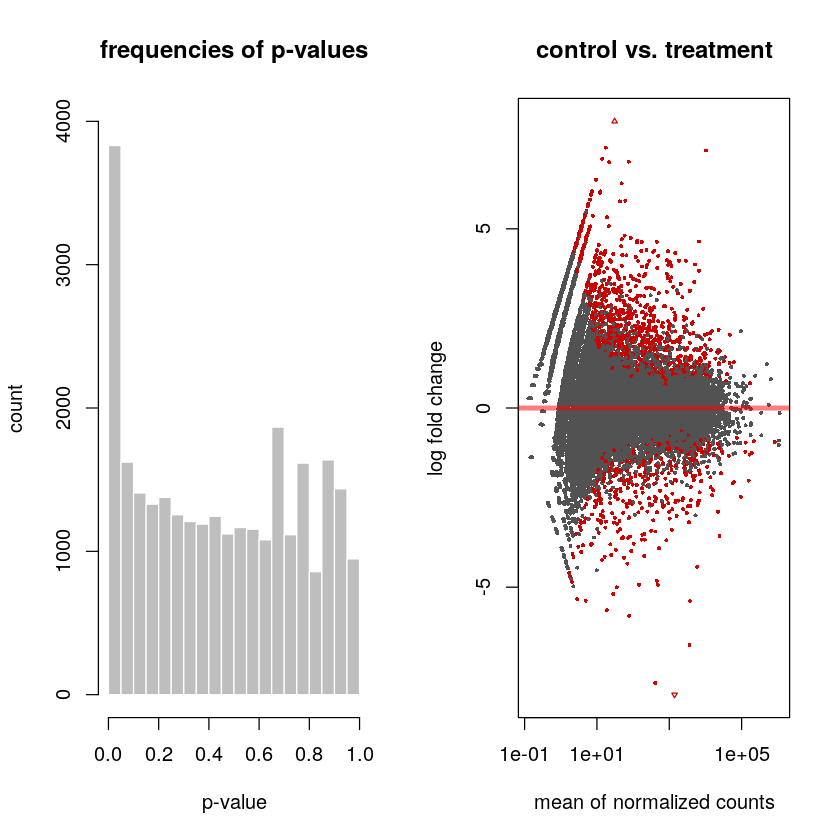

In [61]:
par(mfrow = c(1,2))
hist(DGE.results$pvalue,
    ylim = c(0,4000),
    col = "grey", border = "white", xlab = "p-value", ylab = "count",
    main = "frequencies of p-values")

plotMA(DGE.results, alpha = 0.05, main = "control vs. treatment",
    ylim = c(-8,8))
 

,ctl1,ctl2,ctl3,ctl4,treat1,treat2,treat3,treat4
ENSMUSG00000075015,6.212141,5.514959,5.791530,5.985668,9.420135,9.683783,9.820474,10.1131799
ENSMUSG00000050272,11.291993,10.288533,12.184175,11.424566,2.383007,3.850636,2.610821,0.7990993
ENSMUSG00000009185,9.694770,9.202178,8.812851,9.100959,13.361925,13.304342,12.512516,13.5783387
ENSMUSG00000075014,8.269800,7.437366,7.198314,7.536856,11.398415,11.645018,11.677524,12.2374652
ENSMUSG00000041695,4.108766,4.373807,3.270949,4.052402,7.776036,8.319993,7.943737,7.9736775
ENSMUSG00000000120,13.081942,11.546460,13.270481,12.791669,6.183404,4.799747,7.361701,4.9924936
ENSMUSG00000040026,6.899827,8.001150,6.055589,6.987936,14.968351,13.968345,11.373037,14.9425200
ENSMUSG00000028339,12.339992,12.872787,13.114941,12.897053,5.957341,6.305917,8.113010,8.1368141
ENSMUSG00000048583,5.495535,4.904035,3.867627,4.896511,8.830669,8.352682,9.118381,8.7464080
ENSMUSG00000034009,8.168659,7.688011,10.981603,9.519275,2.057336,2.828407,2.833945,1.3103569


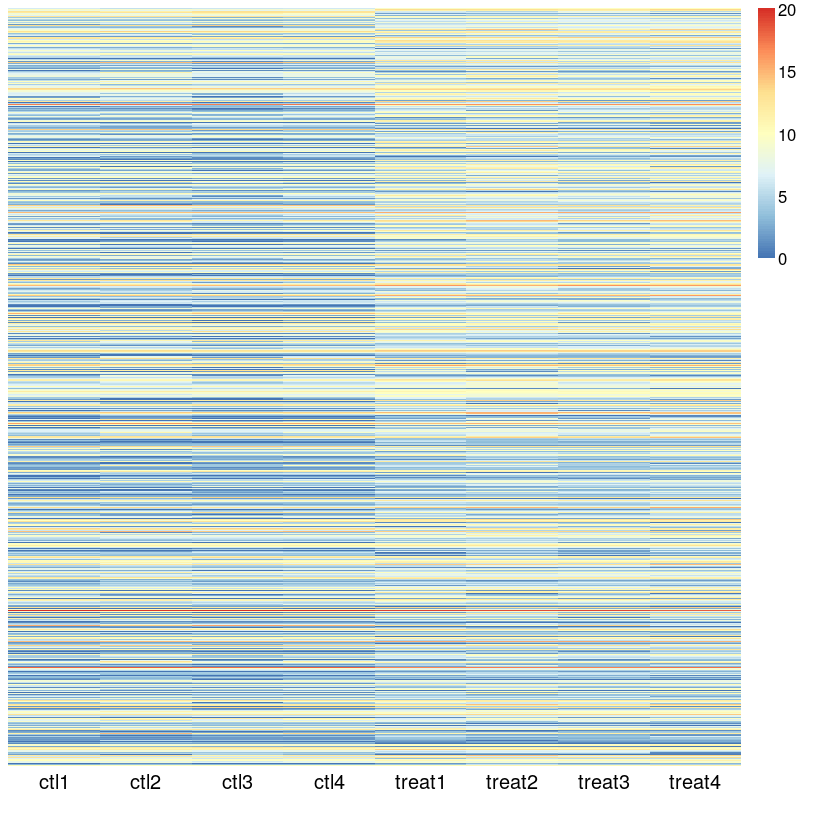

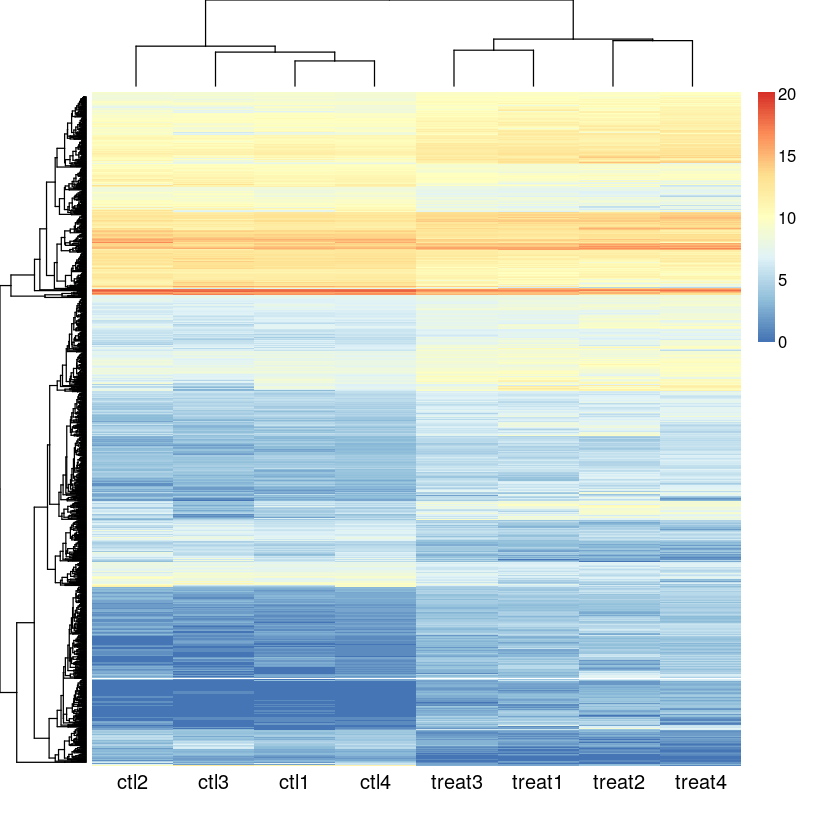

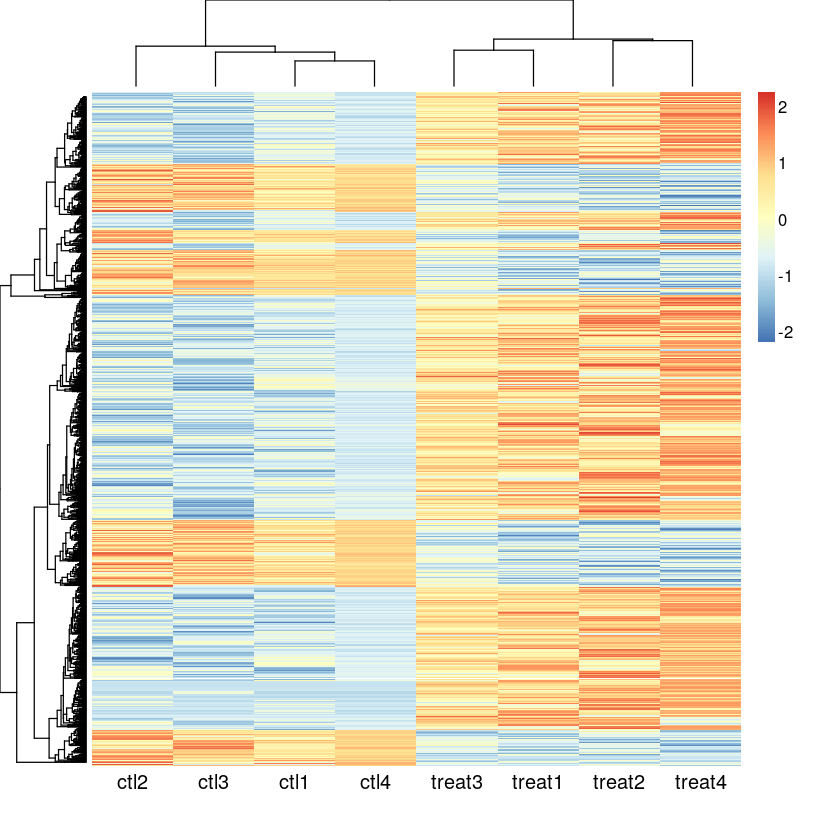

In [82]:

 # aheatmap needs a matrix of values,e.g., a matrix of DE genes with the transformed read counts for each replicate

# sort the results according to the adjusted p - value
DGE.results.sorted <- DGE.results[order(DGE.results$padj),]

#identify genes with the desired adjusted p-value cut-off
DGEgenes <- rownames(subset(DGE.results.sorted, padj < 0.05))
#extract the normalized read counts for DE genes into a matrix
hm.mat_DGEgenes <- log.norm.counts[DGEgenes,]
hm.mat_DGEgenes 
# plot the normalized read counts of DE genes sorted by the adjusted p - value
aheatmap(hm.mat_DGEgenes, Rowv = NA, Colv = NA)

# combine the heatmap with hierarchical clustering
aheatmap(hm.mat_DGEgenes,
    Rowv = TRUE , Colv = TRUE , # add dendrograms to rows and columns
    distfun = "euclidean" , hclustfun = "average" )
 
# scale the read counts per gene to emphasize the sample - type - specific differences
aheatmap (hm.mat_DGEgenes,
    Rowv = TRUE, Colv = TRUE,
    distfun = "euclidean", hclustfun = "average",
    scale = "row") # values are transformed into distances from the centerof the row - specific average : ( actual value - mean of the group ) /standard deviation 

In [77]:

# list the types of keywords that are available to query the annotation database
keytypes(EnsDb.Mmusculus.v75)

 # list columns that can be retrieved from the annotation data base
columns(EnsDb.Mmusculus.v75)

 # make a batch retrieval for all DE genes
anno <- select( EnsDb.Mmusculus.v75,
    keys = DGEgenes, keytype = "GENEID" , # to retrieve all genes : keys = keys (org.Sc.sgd.db)
    columns = c("GENEID" ,"GENENAME"))

anno
 #check whether SNF2 pops up among the top downregulated genes
#DGE . results . sorted _ logFC <- DGE . results [ order ( DGE . results $ log2FoldChange ) , ]
 #DGEgenes _ logFC <- rownames ( subset ( DGE . results . sorted _ logFC , padj < 0.05) )
 #head ( anno [ match ( DGEgenes _ logFC , anno $ ORF ) , ])
 
# find the ORF corresponding to SNF2
#subset ( anno , GENENAME == " SNF2 " )
 
# DESeq2 offers a wrapper function to plot read counts for single genes
#library ( grDevices ) # for italicizing the gene name
#plotCounts ( dds = DESeq . ds ,
 #gene = " YOR290C " ,
 #normalized = TRUE , transform = FALSE ,
 #main = expression ( atop ( " Expression of " * italic ( " snf2 " ) , " ( YOR290C ) ")) )
 

[1] "ENTREZID"            "EXONID"              "GENEBIOTYPE"        
 [4] "GENEID"              "GENENAME"            "PROTDOMID"          
 [7] "PROTEINDOMAINID"     "PROTEINDOMAINSOURCE" "PROTEINID"          
[10] "SEQNAME"             "SEQSTRAND"           "SYMBOL"             
[13] "TXBIOTYPE"           "TXID"                "TXNAME"             
[16] "UNIPROTID"

[1] "ENTREZID"            "EXONID"              "EXONIDX"            
 [4] "EXONSEQEND"          "EXONSEQSTART"        "GENEBIOTYPE"        
 [7] "GENEID"              "GENENAME"            "GENESEQEND"         
[10] "GENESEQSTART"        "INTERPROACCESSION"   "ISCIRCULAR"         
[13] "PROTDOMEND"          "PROTDOMSTART"        "PROTEINDOMAINID"    
[16] "PROTEINDOMAINSOURCE" "PROTEINID"           "PROTEINSEQUENCE"    
[19] "SEQCOORDSYSTEM"      "SEQLENGTH"           "SEQNAME"            
[22] "SEQSTRAND"           "SYMBOL"              "TXBIOTYPE"          
[25] "TXCDSSEQEND"         "TXCDSSEQSTART"       "TXID"               
[28] "TXNAME"              "TXSEQEND"            "TXSEQSTART"         
[31] "UNIPROTDB"           "UNIPROTID"           "UNIPROTMAPPINGTYPE"

GENEID,GENENAME
ENSMUSG00000075015,Gm10801
ENSMUSG00000050272,Dscam
ENSMUSG00000009185,Ccl8
ENSMUSG00000075014,Gm10800
ENSMUSG00000041695,Kcnj2
ENSMUSG00000000120,Ngfr
ENSMUSG00000040026,Saa3
ENSMUSG00000028339,Col15a1
ENSMUSG00000048583,Igf2
ENSMUSG00000034009,Rxfp1
